### === Task ===

1) Learn about TFidVectorizer and replace CountVectorizer with TFIDVectorizer (Explanation Provided in the Lecture)
2) Put Multinomial Naive Classification into a class that can transform the data, fit the model and do prediction.
    - In the class, allow users to choose whether to use CountVectorizer or TFIDVectorizer to transform the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [4]:
print(train.data[0]) #first 300 words
print("Target: ", train.target[0])  #start with 1, soc.religion.christian

From: jono@mac-ak-24.rtsg.mot.com (Jon Ogden)
Subject: Re: Losing your temper is not a Christian trait
Organization: Motorola LPA Development
Lines: 26

In article <Apr.23.02.55.47.1993.3138@geneva.rutgers.edu>, jcj@tellabs.com
(jcj) wrote:

> I'd like to remind people of the withering of the fig tree and Jesus
> driving the money changers et. al. out of the temple.  I think those
> were two instances of Christ showing anger (as part of His human side).
> 
Yes, and what about Paul saying:

26 Be ye angry, and sin not: let not the sun go down upon your wrath:
(Ephesians 4:26).

Obviously then, we can be angry w/o sinning.

Jon

------------------------------------------------
Jon Ogden         - jono@mac-ak-24.rtsg.mot.com
Motorola Cellular - Advanced Products Division
Voice: 708-632-2521      Data: 708-632-6086
------------------------------------------------

They drew a circle and shut him out.
Heretic, Rebel, a thing to flout.
But Love and I had the wit to win;
We drew a circle and 

In [5]:
#let's use some library to count for us
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
class MyMultiNaive:
    def __init__(self, method='count'):
        
        if (method == 'tfid'):
            self.vectorizer = TfidfVectorizer()
        else:
            self.vectorizer = CountVectorizer()

    def tranform(self, train, test):
        X_train = self.vectorizer.fit_transform(train.data)
        X_test = self.vectorizer.transform(test.data)
        X_test = X_test.toarray()
        y_train = train.target
        y_test = test.target
        return X_train, X_test, y_train, y_test
    
    
    def likelihood(self, X_class, laplace=1):
        return ((X_class.sum(axis=0)) + laplace) / (np.sum(X_class.sum(axis=0) + laplace))

    def prior(self, X_class, m):
        return X_class.shape[0] / m

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        classes = np.unique(y_train)  #list of class
        k = len(classes) #number of class

        priors = np.zeros(k) #prior for each classes
        likelihoods = np.zeros((k, n)) #likehood for each class of each feature

        for idx, label in enumerate(classes):
            X_train_c = X_train[y_train==label]
            priors[idx] = self.prior(X_train_c, m)
            likelihoods[idx, :] = self.likelihood(X_train_c)
        self.priors = priors
        self.likelihoods = likelihoods

    def predict(self, X_test, classes):
        return np.log(self.priors) + X_test @ np.log(self.likelihoods.T) 

## Count

In [7]:
method = 'count' # tfid, count
model = MyMultiNaive(method)
X_train, X_test, y_train, y_test = model.tranform(train, test)
model.fit(X_train, y_train)

In [8]:
classes = np.unique(y_test)
yhat = model.predict(X_test, classes)
yhat = np.argmax(yhat, axis=1)

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, classification_report

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

Accuracy:  0.9168994413407822
=========Average precision score=======
Class 0 score:  0.9152047938418233
Class 1 score:  0.9069918620723723
Class 2 score:  0.8429395016564877
Class 3 score:  0.7277310085946386
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.95      0.95      0.95       389
           1       0.94      0.96      0.95       394
           2       0.87      0.95      0.91       398
           3       0.92      0.74      0.82       251

    accuracy                           0.92      1432
   macro avg       0.92      0.90      0.91      1432
weighted avg       0.92      0.92      0.92      1432



Text(32.99999999999999, 0.5, 'predicted')

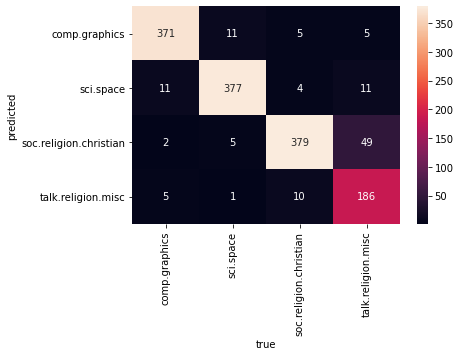

In [10]:
from sklearn.metrics import confusion_matrix

#use confusion matrix
mat = confusion_matrix(y_test, yhat)

import seaborn as sns
sns.heatmap(mat.T, annot=True, fmt="d",
           xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true')
plt.ylabel('predicted')

## TFID

Accuracy:  0.8016759776536313
=========Average precision score=======
Class 0 score:  0.888341920518241
Class 1 score:  0.8744630809734135
Class 2 score:  0.6122064043881043
Class 3 score:  0.332994836297269
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



Text(32.99999999999999, 0.5, 'predicted')

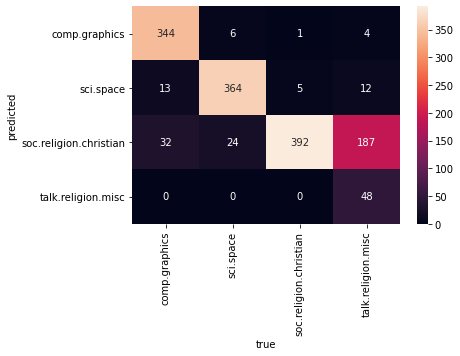

In [11]:
method = 'tfid'
model = MyMultiNaive(method)
X_train, X_test, y_train, y_test = model.tranform(train, test)
model.fit(X_train, y_train)

classes = np.unique(y_test)
yhat = model.predict(X_test, classes)
yhat = np.argmax(yhat, axis=1)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, classification_report

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

from sklearn.metrics import confusion_matrix

#use confusion matrix
mat = confusion_matrix(y_test, yhat)

import seaborn as sns
sns.heatmap(mat.T, annot=True, fmt="d",
           xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true')
plt.ylabel('predicted')